In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import os
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check and set up GPU
def setup_gpu(gpu_index=0):
    # Check total number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Total GPUs available: {num_gpus}")
    
    # Print all GPU names
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Validate requested GPU index
    if gpu_index >= num_gpus:
        print(f"Warning: Requested GPU {gpu_index} not available. Using GPU 0.")
        gpu_index = 0
    
    # Set the specific GPU
    torch.cuda.set_device(gpu_index)
    device = torch.device(f'cuda:{gpu_index}')
    
    print(f"\n🚀 Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
    return device

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Optional: for deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setup device and seed
set_seed(42)
device = setup_gpu(gpu_index=0)  # Explicitly use GPU 1

# Print system information
print(f"PyTorch Version: {torch.__version__}")
print(f"TIMM Version: {timm.__version__}")

# Model hyperparameters - Changed to ViTB32
HYPERPARAMS = {
    'model_name': 'vit_base_patch32_224.augreg_in21k_ft_in1k',  # Changed to ViTB32
    'input_shape': (160, 160, 3),  # Changed to 224x224 for ViT
    'num_classes': 11,  # 11-class classification
    'batch_size': 16,
    'epochs': 60,
    'learning_rate': 1e-4,
    'learning_rate_decay': 0.2,
    'patience_lr': 5,
    'patience_early_stop': 9,
    'validation_split': 0.1,
    'test_split': 0.1,
    'label_smoothing': 0.2,
    'epsilon': 1e-6,
    'weight_decay': 0.01,
    'random_state': 42
}

# Dataset paths - Changed to 11_class_dataset
DATASET_PATH = Path('datasets_paper/11_class_dataset')
MODEL_SAVE_PATH = Path('models/11_class_pytorch')
RESULTS_PATH = Path('results/11_class_pytorch')

# Create directories
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("\n11-Class ViTB32 Classification Setup:")  # Updated to mention ViTB32
for key, value in HYPERPARAMS.items():
    print(f"  {key}: {value}")

Total GPUs available: 2
GPU 0: NVIDIA GeForce RTX 2080 Ti
GPU 1: NVIDIA GeForce RTX 2080 Ti

🚀 Using GPU 0: NVIDIA GeForce RTX 2080 Ti
PyTorch Version: 2.7.1+cu118
TIMM Version: 1.0.16

11-Class ViTB32 Classification Setup:
  model_name: vit_base_patch32_224.augreg_in21k_ft_in1k
  input_shape: (160, 160, 3)
  num_classes: 11
  batch_size: 16
  epochs: 60
  learning_rate: 0.0001
  learning_rate_decay: 0.2
  patience_lr: 5
  patience_early_stop: 9
  validation_split: 0.1
  test_split: 0.1
  label_smoothing: 0.2
  epsilon: 1e-06
  weight_decay: 0.01
  random_state: 42


In [2]:
# Data transforms and dataset loading
train_transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Changed to 160x160 for ViT-B32
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Changed to 160x160 for ViT-B32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load original dataset without transform first to prevent data leakage
full_dataset = ImageFolder(root=DATASET_PATH)
print(f"📊 Dataset Info:")
print(f"Total samples: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")
print(f"Number of classes: {len(full_dataset.classes)}")

# Get labels for stratified split
all_labels = [full_dataset.targets[i] for i in range(len(full_dataset))]

# Calculate dataset splits
total_size = len(full_dataset)
test_size = HYPERPARAMS['test_split']
val_size = HYPERPARAMS['validation_split']

print(f"\nDataset splits:")
print(f"  Train: {1 - test_size - val_size:.1%} of total")
print(f"  Validation: {val_size:.1%} of total")
print(f"  Test: {test_size:.1%} of total")

# Use StratifiedShuffleSplit for stratified splits
from sklearn.model_selection import StratifiedShuffleSplit

# First split: separate test set
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
temp_indices, test_indices = next(sss_test.split(range(len(full_dataset)), all_labels))

# Second split: separate train and validation from remaining data
temp_labels = [all_labels[i] for i in temp_indices]
val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size for remaining data

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size_adjusted, random_state=42)
train_indices, val_indices = next(sss_val.split(temp_indices, temp_labels))

# Convert to actual indices
train_indices = [temp_indices[i] for i in train_indices]
val_indices = [temp_indices[i] for i in val_indices]

print(f"\nActual dataset splits:")
print(f"  Train: {len(train_indices)} samples ({len(train_indices)/total_size*100:.1f}%)")
print(f"  Validation: {len(val_indices)} samples ({len(val_indices)/total_size*100:.1f}%)")
print(f"  Test: {len(test_indices)} samples ({len(test_indices)/total_size*100:.1f}%)")

# Verify stratification by checking class distribution
print(f"\nClass distribution verification:")
for split_name, indices in [("Train", train_indices), ("Val", val_indices), ("Test", test_indices)]:
    split_labels = [all_labels[i] for i in indices]
    class_counts = {}
    for label in split_labels:
        class_name = full_dataset.classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    print(f"  {split_name}: {dict(sorted(class_counts.items()))}")

# Create separate datasets with appropriate transforms
train_dataset = torch.utils.data.Subset(
    ImageFolder(root=DATASET_PATH, transform=train_transform),
    train_indices
)

val_dataset = torch.utils.data.Subset(
    ImageFolder(root=DATASET_PATH, transform=val_test_transform),
    val_indices
)

test_dataset = torch.utils.data.Subset(
    ImageFolder(root=DATASET_PATH, transform=val_test_transform),
    test_indices
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=HYPERPARAMS['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=HYPERPARAMS['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=HYPERPARAMS['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


📊 Dataset Info:
Total samples: 23100
Classes: ['Cell', 'Cell-Multi', 'Cracking', 'Diode', 'Diode-Multi', 'Hot-Spot', 'Hot-Spot-Multi', 'Offline-Module', 'Shadowing', 'Soiling', 'Vegetation']
Number of classes: 11

Dataset splits:
  Train: 80.0% of total
  Validation: 10.0% of total
  Test: 10.0% of total

Actual dataset splits:
  Train: 18480 samples (80.0%)
  Validation: 2310 samples (10.0%)
  Test: 2310 samples (10.0%)

Class distribution verification:
  Train: {'Cell': 1680, 'Cell-Multi': 1680, 'Cracking': 1680, 'Diode': 1680, 'Diode-Multi': 1680, 'Hot-Spot': 1680, 'Hot-Spot-Multi': 1680, 'Offline-Module': 1680, 'Shadowing': 1680, 'Soiling': 1680, 'Vegetation': 1680}
  Val: {'Cell': 210, 'Cell-Multi': 210, 'Cracking': 210, 'Diode': 210, 'Diode-Multi': 210, 'Hot-Spot': 210, 'Hot-Spot-Multi': 210, 'Offline-Module': 210, 'Shadowing': 210, 'Soiling': 210, 'Vegetation': 210}
  Test: {'Cell': 210, 'Cell-Multi': 210, 'Cracking': 210, 'Diode': 210, 'Diode-Multi': 210, 'Hot-Spot': 210, 'Hot-

In [3]:
# Custom ViT-B32 Classifier using TIMM
class ViTB32Classifier(nn.Module):
    def __init__(self, num_classes=11, pretrained=True, dropout_rate=0.3):
        super(ViTB32Classifier, self).__init__()
        
        # Load pre-trained ViT-B/32 from TIMM
        self.backbone = timm.create_model(
            'vit_base_patch32_224',  # ViT-B/32
            pretrained=pretrained,
            num_classes=0,  # Remove head, we'll add custom one
            img_size=160,   # Set input size to 160x160 to match our data
            patch_size=32   # Keep patch size as 32x32
        )
        
        # Get the feature dimension
        self.feature_dim = self.backbone.num_features  # 768 for ViT-B32
        
        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Extract features using ViT backbone
        features = self.backbone(x)
        
        # Apply classification head
        output = self.classifier(features)
        
        return output

# Create model
model = ViTB32Classifier(num_classes=HYPERPARAMS['num_classes']).to(device)

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"🔧 Model Architecture:")
print(f"  Model: ViT-B32 with custom head")
print(f"  Input size: {HYPERPARAMS['input_shape']}")
print(f"  Patch size: 32x32")
print(f"  Hidden dimension: 768")
print(f"  Number of classes: {HYPERPARAMS['num_classes']}")
print(f"  Total trainable parameters: {total_params:,}")

# Print model structure
print(f"\n📋 Model Structure:")
print(model)


🔧 Model Architecture:
  Model: ViT-B32 with custom head
  Input size: (160, 160, 3)
  Patch size: 32x32
  Hidden dimension: 768
  Number of classes: 11
  Total trainable parameters: 87,836,171

📋 Model Structure:
ViTB32Classifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1)

In [4]:
# Label Smoothing CrossEntropy Loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        logprobs = torch.nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Loss function and optimizer
criterion = LabelSmoothingCrossEntropy(smoothing=HYPERPARAMS['label_smoothing'])
optimizer = optim.AdamW(
    model.parameters(),
    lr=HYPERPARAMS['learning_rate'],
    weight_decay=HYPERPARAMS['weight_decay'],
    eps=HYPERPARAMS['epsilon']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=HYPERPARAMS['learning_rate_decay'],
    patience=HYPERPARAMS['patience_lr']
)

print("🎯 Training Configuration:")
print(f"  Loss: CrossEntropy with Label Smoothing ({HYPERPARAMS['label_smoothing']})")
print(f"  Optimizer: AdamW (lr={HYPERPARAMS['learning_rate']}, weight_decay={HYPERPARAMS['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (factor={HYPERPARAMS['learning_rate_decay']}, patience={HYPERPARAMS['patience_lr']})")
print(f"  Early stopping patience: {HYPERPARAMS['patience_early_stop']} epochs")
print(f"  Data split: StratifiedShuffleSplit for balanced class distribution")
print(f"  Classes: 11 anomaly types (Cell, Cell-Multi, Cracking, Diode, Diode-Multi, Hot-Spot, Hot-Spot-Multi, Offline-Module, Shadowing, Soiling, Vegetation)")


🎯 Training Configuration:
  Loss: CrossEntropy with Label Smoothing (0.2)
  Optimizer: AdamW (lr=0.0001, weight_decay=0.01)
  Scheduler: ReduceLROnPlateau (factor=0.2, patience=5)
  Early stopping patience: 9 epochs
  Data split: StratifiedShuffleSplit for balanced class distribution
  Classes: 11 anomaly types (Cell, Cell-Multi, Cracking, Diode, Diode-Multi, Hot-Spot, Hot-Spot-Multi, Offline-Module, Shadowing, Soiling, Vegetation)


In [5]:
# Training and validation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation', leave=False)
        
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = val_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Training and validation functions defined")
print("📝 Note: These functions work with any data loaders, including those from StratifiedShuffleSplit")


✅ Training and validation functions defined
📝 Note: These functions work with any data loaders, including those from StratifiedShuffleSplit


In [6]:
# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, patience, device, save_path):
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    start_time = datetime.now()
    
    print(f"🚀 Starting training for {num_epochs} epochs...")
    print(f"📅 Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print("-" * 80)
    
    for epoch in range(num_epochs):
        epoch_start = datetime.now()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nEpoch {epoch+1}/{num_epochs} | LR: {current_lr:.2e}")
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        
        # Calculate epoch time
        epoch_time = datetime.now() - epoch_start
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"Time: {epoch_time.total_seconds():.1f}s")
        
        # Check for best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'hyperparams': HYPERPARAMS
            }, save_path / 'best_vitb32_11class.pth')
            
            print(f"✅ New best model saved! (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"⏳ Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered after {epoch + 1} epochs")
            print(f"Best validation loss: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)")
            break
    
    total_time = datetime.now() - start_time
    print(f"\n🏁 Training completed!")
    print(f"⏱️  Total time: {total_time}")
    print(f"🎯 Best validation accuracy: {best_val_acc:.2f}%")
    
    return history

print("✅ Training function defined")
print("📝 Note: This function works with any data loaders, including those from StratifiedShuffleSplit")


✅ Training function defined
📝 Note: This function works with any data loaders, including those from StratifiedShuffleSplit


In [7]:
# Start training with StratifiedShuffleSplit
print("🎯 Starting 11-Class ViT-B32 Training with StratifiedShuffleSplit...")
print(f"📊 Dataset: {len(full_dataset.classes)} classes, {len(full_dataset)} total images")
print(f"🏗️  Model: ViT-B32 with {count_parameters(model):,} parameters")
print(f"🔄 Using StratifiedShuffleSplit for balanced train/validation splits")

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=HYPERPARAMS['epochs'],
    patience=HYPERPARAMS['patience_early_stop'],
    device=device,
    save_path=MODEL_SAVE_PATH
)


🎯 Starting 11-Class ViT-B32 Training with StratifiedShuffleSplit...
📊 Dataset: 11 classes, 23100 total images
🏗️  Model: ViT-B32 with 87,836,171 parameters
🔄 Using StratifiedShuffleSplit for balanced train/validation splits
🚀 Starting training for 60 epochs...
📅 Start time: 2025-07-05 07:49:16
--------------------------------------------------------------------------------

Epoch 1/60 | LR: 1.00e-04


Train Loss: 1.8871 | Train Acc: 44.77%
Val Loss:   1.5224 | Val Acc:   65.97%
Time: 101.6s
✅ New best model saved! (Val Loss: 1.5224)

Epoch 2/60 | LR: 1.00e-04


Train Loss: 1.5124 | Train Acc: 66.60%
Val Loss:   1.4123 | Val Acc:   70.91%
Time: 101.4s
✅ New best model saved! (Val Loss: 1.4123)

Epoch 3/60 | LR: 1.00e-04


Train Loss: 1.3835 | Train Acc: 73.71%
Val Loss:   1.2806 | Val Acc:   79.13%
Time: 101.8s
✅ New best model saved! (Val Loss: 1.2806)

Epoch 4/60 | LR: 1.00e-04


Train Loss: 1.2890 | Train Acc: 79.03%
Val Loss:   1.2496 | Val Acc:   80.69%
Time: 101.7s
✅ New best model saved! (Val Loss: 1.2496)

Epoch 5/60 | LR: 1.00e-04


Train Loss: 1.2295 | Train Acc: 82.59%
Val Loss:   1.2033 | Val Acc:   82.99%
Time: 101.0s
✅ New best model saved! (Val Loss: 1.2033)

Epoch 6/60 | LR: 1.00e-04


Train Loss: 1.1856 | Train Acc: 84.91%
Val Loss:   1.2163 | Val Acc:   82.68%
Time: 100.4s
⏳ Patience: 1/9

Epoch 7/60 | LR: 1.00e-04


Train Loss: 1.1476 | Train Acc: 86.80%
Val Loss:   1.1819 | Val Acc:   84.63%
Time: 101.5s
✅ New best model saved! (Val Loss: 1.1819)

Epoch 8/60 | LR: 1.00e-04


Train Loss: 1.1167 | Train Acc: 88.67%
Val Loss:   1.2027 | Val Acc:   83.72%
Time: 100.5s
⏳ Patience: 1/9

Epoch 9/60 | LR: 1.00e-04


Train Loss: 1.0995 | Train Acc: 89.64%
Val Loss:   1.1722 | Val Acc:   84.85%
Time: 100.9s
✅ New best model saved! (Val Loss: 1.1722)

Epoch 10/60 | LR: 1.00e-04


Train Loss: 1.0752 | Train Acc: 90.98%
Val Loss:   1.1531 | Val Acc:   87.01%
Time: 111.6s
✅ New best model saved! (Val Loss: 1.1531)

Epoch 11/60 | LR: 1.00e-04


Train Loss: 1.0680 | Train Acc: 91.37%
Val Loss:   1.1477 | Val Acc:   87.14%
Time: 103.9s
✅ New best model saved! (Val Loss: 1.1477)

Epoch 12/60 | LR: 1.00e-04


Train Loss: 1.0459 | Train Acc: 92.60%
Val Loss:   1.1763 | Val Acc:   85.24%
Time: 102.7s
⏳ Patience: 1/9

Epoch 13/60 | LR: 1.00e-04


Train Loss: 1.0395 | Train Acc: 92.82%
Val Loss:   1.1503 | Val Acc:   86.45%
Time: 102.4s
⏳ Patience: 2/9

Epoch 14/60 | LR: 1.00e-04


Train Loss: 1.0215 | Train Acc: 93.89%
Val Loss:   1.1511 | Val Acc:   87.27%
Time: 102.0s
⏳ Patience: 3/9

Epoch 15/60 | LR: 1.00e-04


Train Loss: 1.0229 | Train Acc: 93.84%
Val Loss:   1.0997 | Val Acc:   89.00%
Time: 100.5s
✅ New best model saved! (Val Loss: 1.0997)

Epoch 16/60 | LR: 1.00e-04


Train Loss: 1.0079 | Train Acc: 94.57%
Val Loss:   1.0829 | Val Acc:   90.65%
Time: 101.4s
✅ New best model saved! (Val Loss: 1.0829)

Epoch 17/60 | LR: 1.00e-04


Train Loss: 1.0040 | Train Acc: 94.64%
Val Loss:   1.0873 | Val Acc:   90.17%
Time: 102.3s
⏳ Patience: 1/9

Epoch 18/60 | LR: 1.00e-04


Train Loss: 0.9973 | Train Acc: 95.17%
Val Loss:   1.0833 | Val Acc:   90.82%
Time: 103.5s
⏳ Patience: 2/9

Epoch 19/60 | LR: 1.00e-04


Train Loss: 0.9920 | Train Acc: 95.45%
Val Loss:   1.0743 | Val Acc:   91.30%
Time: 102.8s
✅ New best model saved! (Val Loss: 1.0743)

Epoch 20/60 | LR: 1.00e-04


Train Loss: 0.9905 | Train Acc: 95.50%
Val Loss:   1.0782 | Val Acc:   91.13%
Time: 103.6s
⏳ Patience: 1/9

Epoch 21/60 | LR: 1.00e-04


Train Loss: 0.9847 | Train Acc: 95.68%
Val Loss:   1.0924 | Val Acc:   90.61%
Time: 101.7s
⏳ Patience: 2/9

Epoch 22/60 | LR: 1.00e-04


Train Loss: 0.9781 | Train Acc: 96.11%
Val Loss:   1.1150 | Val Acc:   89.13%
Time: 100.9s
⏳ Patience: 3/9

Epoch 23/60 | LR: 1.00e-04


Train Loss: 0.9769 | Train Acc: 96.17%
Val Loss:   1.1007 | Val Acc:   90.00%
Time: 101.3s
⏳ Patience: 4/9

Epoch 24/60 | LR: 1.00e-04


Train Loss: 0.9704 | Train Acc: 96.58%
Val Loss:   1.0832 | Val Acc:   90.91%
Time: 108.5s
⏳ Patience: 5/9

Epoch 25/60 | LR: 1.00e-04


Train Loss: 0.9720 | Train Acc: 96.49%
Val Loss:   1.0625 | Val Acc:   91.95%
Time: 103.0s
✅ New best model saved! (Val Loss: 1.0625)

Epoch 26/60 | LR: 1.00e-04


Train Loss: 0.9675 | Train Acc: 96.66%
Val Loss:   1.0737 | Val Acc:   91.30%
Time: 102.3s
⏳ Patience: 1/9

Epoch 27/60 | LR: 1.00e-04


Train Loss: 0.9661 | Train Acc: 96.76%
Val Loss:   1.0900 | Val Acc:   90.91%
Time: 102.9s
⏳ Patience: 2/9

Epoch 28/60 | LR: 1.00e-04


Train Loss: 0.9641 | Train Acc: 96.87%
Val Loss:   1.0830 | Val Acc:   91.34%
Time: 102.4s
⏳ Patience: 3/9

Epoch 29/60 | LR: 1.00e-04


Train Loss: 0.9636 | Train Acc: 96.82%
Val Loss:   1.0714 | Val Acc:   92.08%
Time: 101.6s
⏳ Patience: 4/9

Epoch 30/60 | LR: 1.00e-04


Train Loss: 0.9578 | Train Acc: 97.18%
Val Loss:   1.0667 | Val Acc:   91.90%
Time: 101.7s
⏳ Patience: 5/9

Epoch 31/60 | LR: 1.00e-04


Train Loss: 0.9577 | Train Acc: 97.15%
Val Loss:   1.0503 | Val Acc:   92.29%
Time: 102.0s
✅ New best model saved! (Val Loss: 1.0503)

Epoch 32/60 | LR: 1.00e-04


Train Loss: 0.9567 | Train Acc: 97.15%
Val Loss:   1.0681 | Val Acc:   91.95%
Time: 101.8s
⏳ Patience: 1/9

Epoch 33/60 | LR: 1.00e-04


Train Loss: 0.9534 | Train Acc: 97.40%
Val Loss:   1.0582 | Val Acc:   92.42%
Time: 104.4s
⏳ Patience: 2/9

Epoch 34/60 | LR: 1.00e-04


Train Loss: 0.9527 | Train Acc: 97.30%
Val Loss:   1.0871 | Val Acc:   91.21%
Time: 106.7s
⏳ Patience: 3/9

Epoch 35/60 | LR: 1.00e-04


Train Loss: 0.9524 | Train Acc: 97.40%
Val Loss:   1.0801 | Val Acc:   91.82%
Time: 106.9s
⏳ Patience: 4/9

Epoch 36/60 | LR: 1.00e-04


Train Loss: 0.9472 | Train Acc: 97.71%
Val Loss:   1.0614 | Val Acc:   92.34%
Time: 103.0s
⏳ Patience: 5/9

Epoch 37/60 | LR: 1.00e-04


Train Loss: 0.9548 | Train Acc: 97.29%
Val Loss:   1.0599 | Val Acc:   92.64%
Time: 102.6s
⏳ Patience: 6/9

Epoch 38/60 | LR: 2.00e-05


Train Loss: 0.9170 | Train Acc: 99.28%
Val Loss:   1.0322 | Val Acc:   93.85%
Time: 105.0s
✅ New best model saved! (Val Loss: 1.0322)

Epoch 39/60 | LR: 2.00e-05


Train Loss: 0.9075 | Train Acc: 99.72%
Val Loss:   1.0260 | Val Acc:   93.94%
Time: 106.5s
✅ New best model saved! (Val Loss: 1.0260)

Epoch 40/60 | LR: 2.00e-05


Train Loss: 0.9074 | Train Acc: 99.70%
Val Loss:   1.0200 | Val Acc:   94.55%
Time: 105.5s
✅ New best model saved! (Val Loss: 1.0200)

Epoch 41/60 | LR: 2.00e-05


Train Loss: 0.9058 | Train Acc: 99.75%
Val Loss:   1.0202 | Val Acc:   94.46%
Time: 103.5s
⏳ Patience: 1/9

Epoch 42/60 | LR: 2.00e-05


Train Loss: 0.9058 | Train Acc: 99.75%
Val Loss:   1.0203 | Val Acc:   94.24%
Time: 100.5s
⏳ Patience: 2/9

Epoch 43/60 | LR: 2.00e-05


Train Loss: 0.9065 | Train Acc: 99.71%
Val Loss:   1.0186 | Val Acc:   94.63%
Time: 101.7s
✅ New best model saved! (Val Loss: 1.0186)

Epoch 44/60 | LR: 2.00e-05


Train Loss: 0.9044 | Train Acc: 99.79%
Val Loss:   1.0196 | Val Acc:   94.68%
Time: 102.6s
⏳ Patience: 1/9

Epoch 45/60 | LR: 2.00e-05


Train Loss: 0.9051 | Train Acc: 99.76%
Val Loss:   1.0277 | Val Acc:   94.37%
Time: 99.8s
⏳ Patience: 2/9

Epoch 46/60 | LR: 2.00e-05


Train Loss: 0.9028 | Train Acc: 99.87%
Val Loss:   1.0292 | Val Acc:   94.20%
Time: 102.4s
⏳ Patience: 3/9

Epoch 47/60 | LR: 2.00e-05


Train Loss: 0.9050 | Train Acc: 99.76%
Val Loss:   1.0235 | Val Acc:   94.33%
Time: 103.9s
⏳ Patience: 4/9

Epoch 48/60 | LR: 2.00e-05


Train Loss: 0.9047 | Train Acc: 99.76%
Val Loss:   1.0276 | Val Acc:   94.20%
Time: 104.0s
⏳ Patience: 5/9

Epoch 49/60 | LR: 2.00e-05


Train Loss: 0.9035 | Train Acc: 99.84%
Val Loss:   1.0246 | Val Acc:   94.55%
Time: 104.0s
⏳ Patience: 6/9

Epoch 50/60 | LR: 4.00e-06


Train Loss: 0.9017 | Train Acc: 99.92%
Val Loss:   1.0181 | Val Acc:   94.72%
Time: 103.7s
✅ New best model saved! (Val Loss: 1.0181)

Epoch 51/60 | LR: 4.00e-06


Train Loss: 0.9015 | Train Acc: 99.92%
Val Loss:   1.0184 | Val Acc:   94.55%
Time: 102.4s
⏳ Patience: 1/9

Epoch 52/60 | LR: 4.00e-06


Train Loss: 0.9010 | Train Acc: 99.93%
Val Loss:   1.0205 | Val Acc:   94.46%
Time: 103.3s
⏳ Patience: 2/9

Epoch 53/60 | LR: 4.00e-06


Train Loss: 0.9007 | Train Acc: 99.94%
Val Loss:   1.0198 | Val Acc:   94.37%
Time: 100.3s
⏳ Patience: 3/9

Epoch 54/60 | LR: 4.00e-06


Train Loss: 0.9010 | Train Acc: 99.94%
Val Loss:   1.0203 | Val Acc:   94.46%
Time: 98.9s
⏳ Patience: 4/9

Epoch 55/60 | LR: 4.00e-06


Train Loss: 0.9007 | Train Acc: 99.92%
Val Loss:   1.0213 | Val Acc:   94.37%
Time: 96.2s
⏳ Patience: 5/9

Epoch 56/60 | LR: 4.00e-06


Train Loss: 0.9008 | Train Acc: 99.94%
Val Loss:   1.0209 | Val Acc:   94.33%
Time: 95.9s
⏳ Patience: 6/9

Epoch 57/60 | LR: 8.00e-07


Train Loss: 0.9008 | Train Acc: 99.94%
Val Loss:   1.0213 | Val Acc:   94.24%
Time: 96.0s
⏳ Patience: 7/9

Epoch 58/60 | LR: 8.00e-07


Train Loss: 0.9003 | Train Acc: 99.96%
Val Loss:   1.0204 | Val Acc:   94.37%
Time: 95.8s
⏳ Patience: 8/9

Epoch 59/60 | LR: 8.00e-07


Train Loss: 0.9004 | Train Acc: 99.96%
Val Loss:   1.0205 | Val Acc:   94.29%
Time: 95.9s
⏳ Patience: 9/9

🛑 Early stopping triggered after 59 epochs
Best validation loss: 1.0181 (Acc: 94.72%)

🏁 Training completed!
⏱️  Total time: 1:40:58.228830
🎯 Best validation accuracy: 94.72%


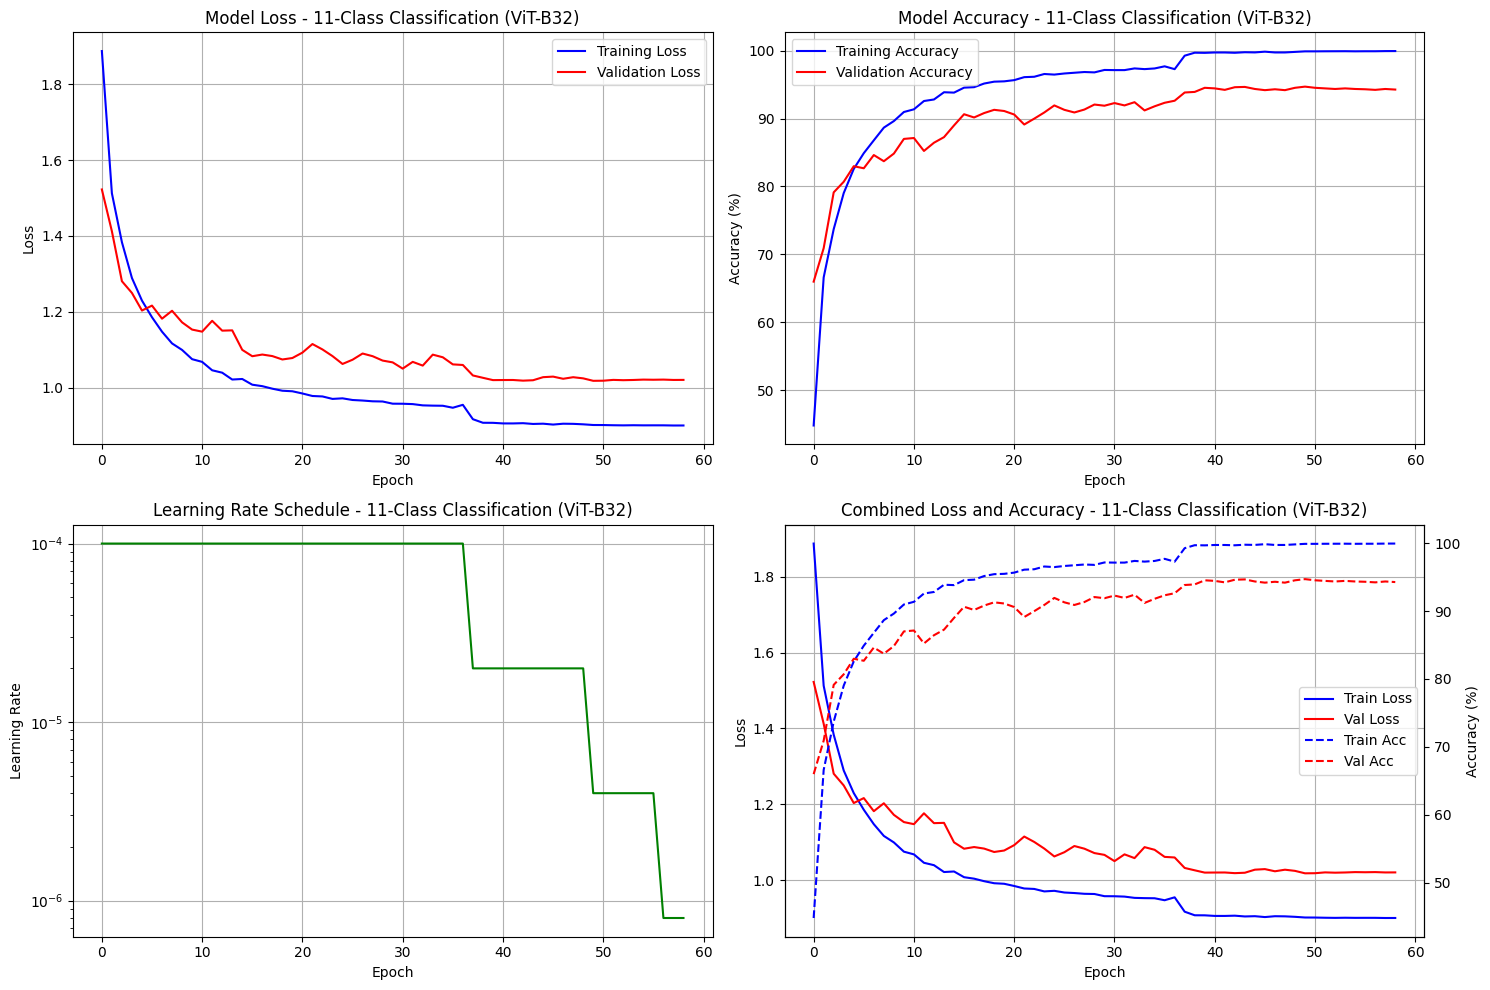

📊 Training plots saved to results\11_class_pytorch/training_history_vitb32_11class_stratified.png
💾 Training history saved to results\11_class_pytorch/training_history_vitb32_11class_stratified.json


In [8]:
# Plot training history and save results
def plot_training_history(history, save_path):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Model Loss - 11-Class Classification (ViT-B32)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy plot
    axes[0, 1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0, 1].set_title('Model Accuracy - 11-Class Classification (ViT-B32)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Learning rate plot
    axes[1, 0].plot(history['learning_rates'], color='green')
    axes[1, 0].set_title('Learning Rate Schedule - 11-Class Classification (ViT-B32)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)
    
    # Combined loss and accuracy
    ax1 = axes[1, 1]
    ax2 = ax1.twinx()
    
    line1 = ax1.plot(history['train_loss'], 'b-', label='Train Loss')
    line2 = ax1.plot(history['val_loss'], 'r-', label='Val Loss')
    line3 = ax2.plot(history['train_acc'], 'b--', label='Train Acc')
    line4 = ax2.plot(history['val_acc'], 'r--', label='Val Acc')
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='black')
    ax2.set_ylabel('Accuracy (%)', color='black')
    ax1.set_title('Combined Loss and Accuracy - 11-Class Classification (ViT-B32)')
    
    # Combine legends
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    ax1.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path / 'training_history_vitb32_11class_stratified.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot and save training history
plot_training_history(history, RESULTS_PATH)

# Save training history as JSON
with open(RESULTS_PATH / 'training_history_vitb32_11class_stratified.json', 'w') as f:
    json.dump(history, f, indent=4)

print(f"📊 Training plots saved to {RESULTS_PATH}/training_history_vitb32_11class_stratified.png")
print(f"💾 Training history saved to {RESULTS_PATH}/training_history_vitb32_11class_stratified.json")


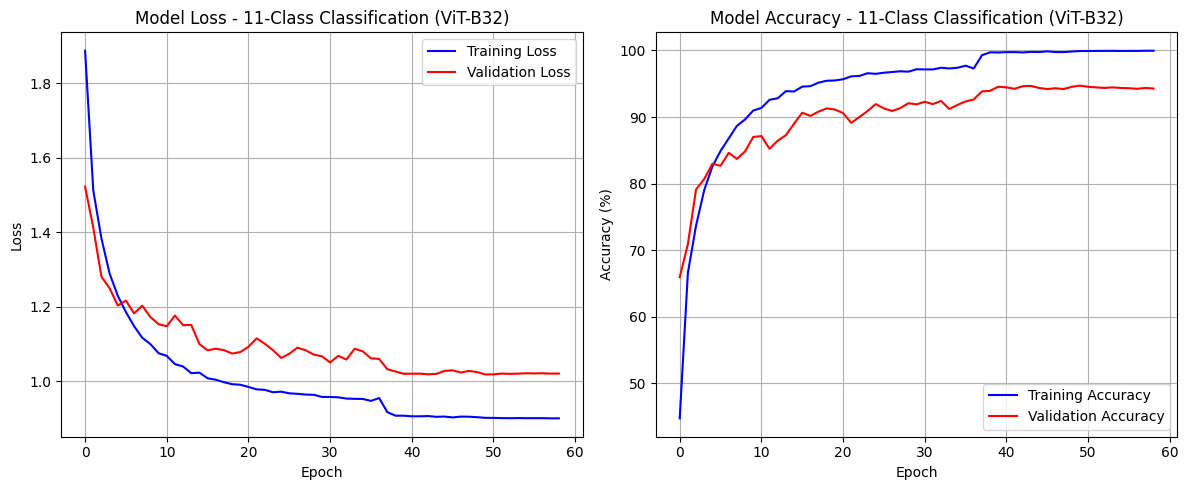

📊 Training plots saved to results\11_class_pytorch/training_history_vitb32_11class_stratified.png
💾 Training history saved to results\11_class_pytorch/training_history_vitb32_11class_stratified.json


In [9]:
# Plot training history and save results
def plot_training_history(history, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0].set_title('Model Loss - 11-Class Classification (ViT-B32)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[1].set_title('Model Accuracy - 11-Class Classification (ViT-B32)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path / 'training_history_vitb32_11class_stratified.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot and save training history
plot_training_history(history, RESULTS_PATH)

# Save training history as JSON
with open(RESULTS_PATH / 'training_history_vitb32_11class_stratified.json', 'w') as f:
    json.dump(history, f, indent=4)

print(f"📊 Training plots saved to {RESULTS_PATH}/training_history_vitb32_11class_stratified.png")
print(f"💾 Training history saved to {RESULTS_PATH}/training_history_vitb32_11class_stratified.json")


In [10]:
# Check if best model exists, if not use current model state
model_path = MODEL_SAVE_PATH / 'best_model_vitb32_11class_stratified.pth'

if model_path.exists():
    # Load best model and evaluate
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Best ViT-B32 model loaded from epoch {checkpoint['epoch']}")
    print(f"📊 Validation accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"📊 Validation loss: {checkpoint['val_loss']:.4f}")
else:
    print("⚠️ Best model checkpoint not found. Using current model state for evaluation.")
    model.eval()

# Evaluation function
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing ViT-B32')
        
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    
    # Classification report
    class_report = classification_report(
        all_targets, all_predictions,
        target_names=class_names,
        digits=4
    )
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    return {
        'accuracy': accuracy,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'classification_report': class_report,
        'confusion_matrix': cm
    }

# Evaluate on test set
test_results = evaluate_model(model, test_loader, device, full_dataset.classes)

print(f"\n🎯 ViT-B32 Test Results:")
print(f"  Test Accuracy: {test_results['accuracy']*100:.2f}%")
print(f"\n📋 Classification Report:")
print(test_results['classification_report'])


⚠️ Best model checkpoint not found. Using current model state for evaluation.


Testing ViT-B32: 100%|██████████| 145/145 [00:21<00:00,  6.73it/s]


🎯 ViT-B32 Test Results:
  Test Accuracy: 94.16%

📋 Classification Report:
                precision    recall  f1-score   support

          Cell     0.8084    0.8238    0.8160       210
    Cell-Multi     0.9000    0.8571    0.8780       210
      Cracking     0.9442    0.9667    0.9553       210
         Diode     0.9951    0.9714    0.9831       210
   Diode-Multi     0.9953    1.0000    0.9976       210
      Hot-Spot     0.9858    0.9952    0.9905       210
Hot-Spot-Multi     0.9722    1.0000    0.9859       210
Offline-Module     0.9712    0.9619    0.9665       210
     Shadowing     0.9231    0.9714    0.9466       210
       Soiling     0.9812    0.9952    0.9882       210
    Vegetation     0.8769    0.8143    0.8444       210

      accuracy                         0.9416      2310
     macro avg     0.9412    0.9416    0.9411      2310
  weighted avg     0.9412    0.9416    0.9411      2310



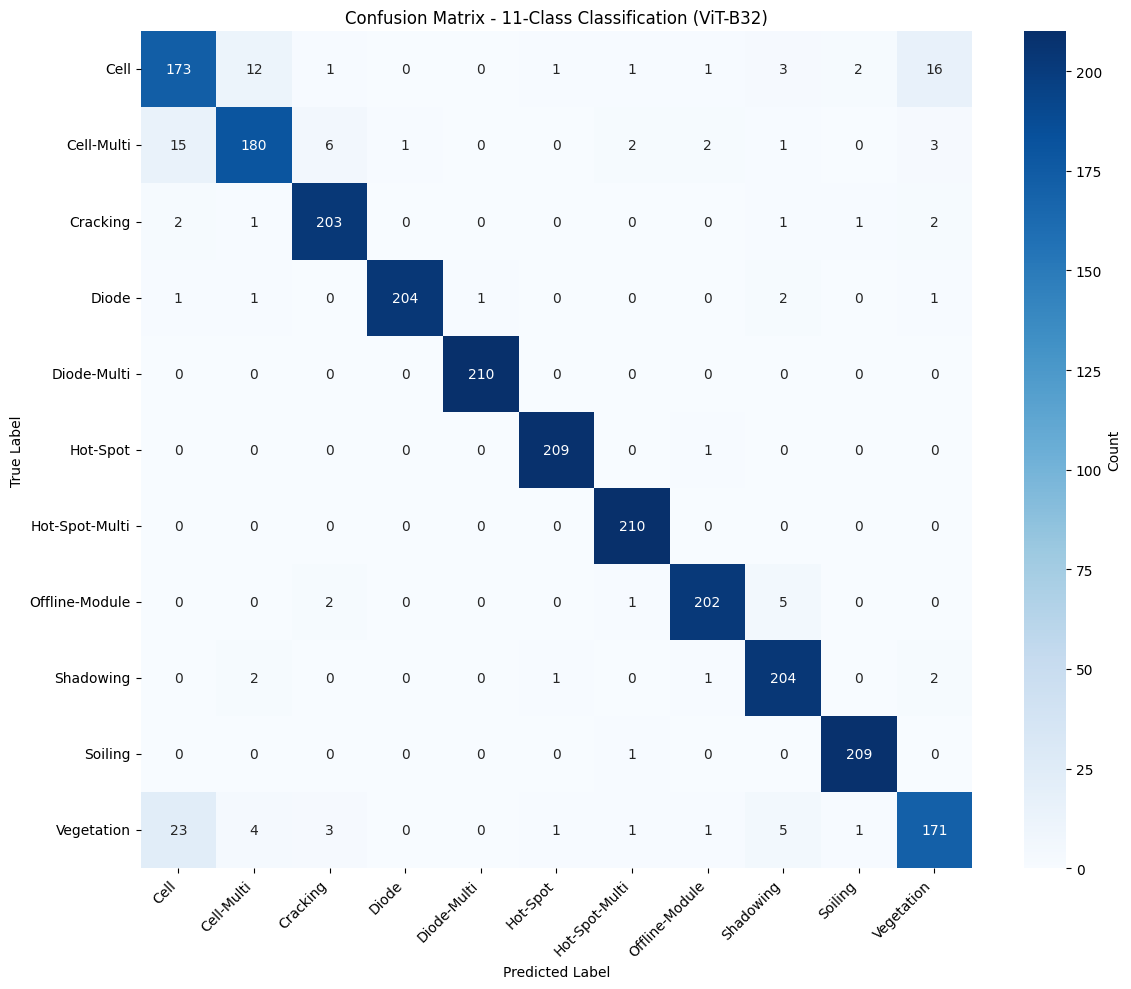

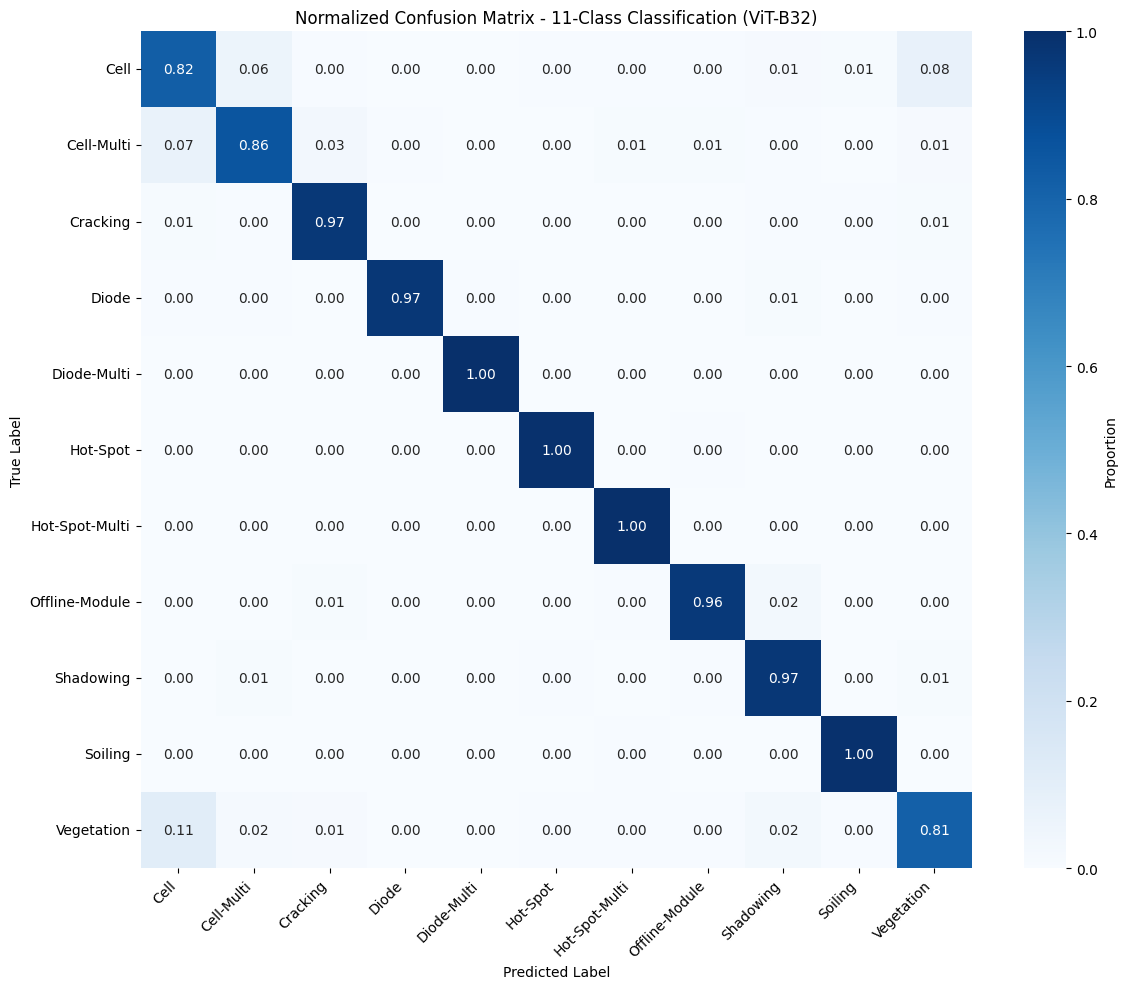

📊 Per-Class Performance:
--------------------------------------------------
Cell           :  82.38% ( 173/ 210)
Cell-Multi     :  85.71% ( 180/ 210)
Cracking       :  96.67% ( 203/ 210)
Diode          :  97.14% ( 204/ 210)
Diode-Multi    : 100.00% ( 210/ 210)
Hot-Spot       :  99.52% ( 209/ 210)
Hot-Spot-Multi : 100.00% ( 210/ 210)
Offline-Module :  96.19% ( 202/ 210)
Shadowing      :  97.14% ( 204/ 210)
Soiling        :  99.52% ( 209/ 210)
Vegetation     :  81.43% ( 171/ 210)
--------------------------------------------------
Overall        :  94.16%


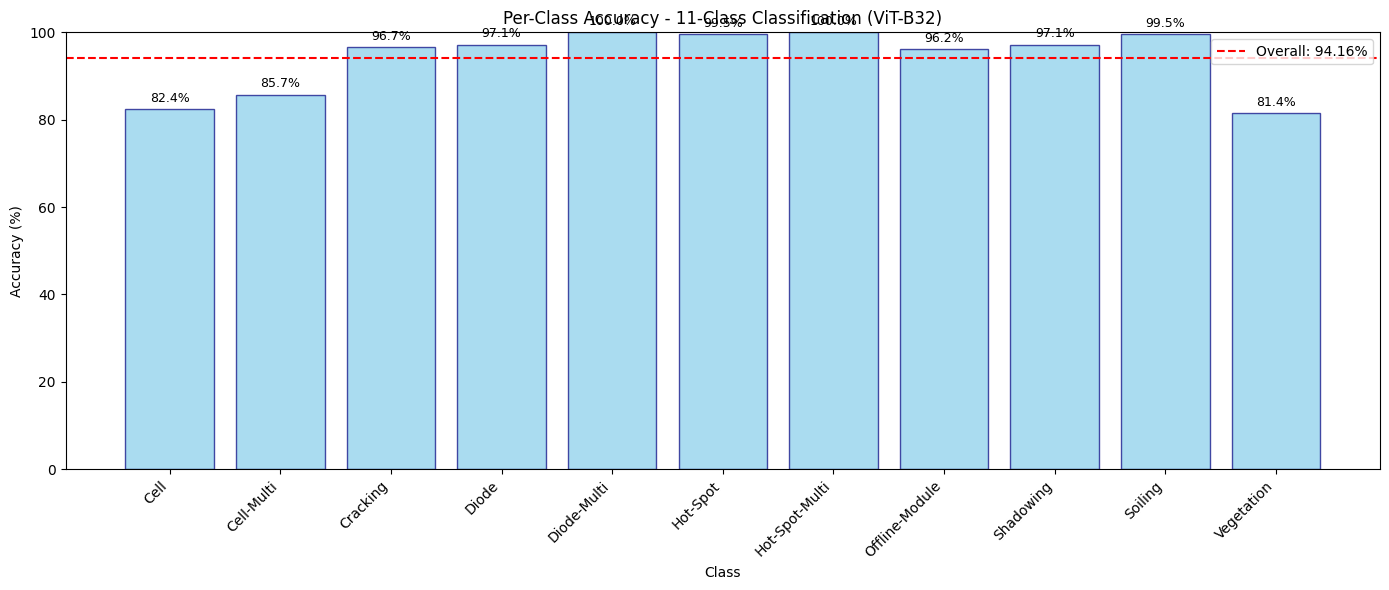

📊 Confusion matrices and analysis plots saved to results\11_class_pytorch/


In [11]:
# Plot confusion matrix and per-class analysis
def plot_confusion_matrix(cm, class_names, save_path, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix - 11-Class Classification (ViT-B32)'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix - 11-Class Classification (ViT-B32)'
        fmt = 'd'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    filename = 'confusion_matrix_normalized_11class.png' if normalize else 'confusion_matrix_11class.png'
    plt.savefig(save_path / filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot both normalized and non-normalized confusion matrices
plot_confusion_matrix(test_results['confusion_matrix'], full_dataset.classes, RESULTS_PATH, normalize=False)
plot_confusion_matrix(test_results['confusion_matrix'], full_dataset.classes, RESULTS_PATH, normalize=True)

# Per-class accuracy analysis
def analyze_per_class_performance(cm, class_names):
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    print("📊 Per-Class Performance:")
    print("-" * 50)
    
    results = []
    for i, (class_name, acc) in enumerate(zip(class_names, per_class_acc)):
        total_samples = cm.sum(axis=1)[i]
        correct_samples = cm.diagonal()[i]
        
        print(f"{class_name:15s}: {acc*100:6.2f}% ({correct_samples:4d}/{total_samples:4d})")
        
        results.append({
            'class': class_name,
            'accuracy': acc,
            'correct': int(correct_samples),
            'total': int(total_samples)
        })
    
    print("-" * 50)
    print(f"{'Overall':15s}: {test_results['accuracy']*100:6.2f}%")
    
    return results

# Analyze per-class performance
per_class_results = analyze_per_class_performance(test_results['confusion_matrix'], full_dataset.classes)

# Create a bar plot for per-class accuracies
plt.figure(figsize=(14, 6))
classes = [r['class'] for r in per_class_results]
accuracies = [r['accuracy'] * 100 for r in per_class_results]

bars = plt.bar(classes, accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Per-Class Accuracy - 11-Class Classification (ViT-B32)')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

# Add overall accuracy line
plt.axhline(y=test_results['accuracy']*100, color='red', linestyle='--', 
            label=f'Overall: {test_results["accuracy"]*100:.2f}%')
plt.legend()

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'per_class_accuracy_11class.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Confusion matrices and analysis plots saved to {RESULTS_PATH}/")


In [12]:
# Testing the Model with Custom Images

import os
from PIL import Image
import torch.nn.functional as F

def test_single_image(model, image_path, transform, device, classes):
    """
    Test a single image with the trained model
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class_idx].item()
    
    predicted_class = classes[predicted_class_idx]
    
    return predicted_class, confidence, probabilities[0]

def test_custom_images(model, image_directory, transform, device, classes):
    """
    Test multiple images from a directory
    """
    if not os.path.exists(image_directory):
        print(f"Directory {image_directory} does not exist!")
        return
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(image_directory) 
                   if any(f.lower().endswith(ext) for ext in image_extensions)]
    
    if not image_files:
        print(f"No image files found in {image_directory}")
        return
    
    print(f"Testing {len(image_files)} images from {image_directory}")
    print("-" * 60)
    
    results = []
    for image_file in image_files[:10]:  # Test first 10 images
        image_path = os.path.join(image_directory, image_file)
        try:
            predicted_class, confidence, all_probs = test_single_image(
                model, image_path, transform, device, classes
            )
            
            print(f"Image: {image_file:25s} | Predicted: {predicted_class:15s} | Confidence: {confidence:.3f}")
            
            results.append({
                'image': image_file,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'probabilities': all_probs.cpu().numpy()
            })
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
    
    return results

# Example usage - Test with validation set samples
print("🧪 Testing Model with Sample Images")
print("=" * 60)

# Test with some validation images (uses StratifiedShuffleSplit split data)
val_loader_single = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True
)

# Test a few random validation samples from the stratified split
print("\n📋 Testing Random Validation Samples (from StratifiedShuffleSplit):")
print("-" * 60)

model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader_single):
        if i >= 5:  # Test only 5 samples
            break
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        confidence = probabilities[0][predicted].item()
        
        true_class = full_dataset.classes[labels.item()]
        pred_class = full_dataset.classes[predicted.item()]
        
        status = "✅" if predicted.item() == labels.item() else "❌"
        
        print(f"Sample {i+1}: True: {true_class:15s} | Pred: {pred_class:15s} | "
              f"Confidence: {confidence:.3f} | {status}")

# Instructions for testing custom images
print("\n" + "=" * 60)
print("📁 To test your own images:")
print("1. Place your thermal images in a folder")
print("2. Use the test_custom_images() function:")
print("   results = test_custom_images(model, 'path/to/your/images/', transform, device, full_dataset.classes)")
print("\n3. Or test a single image:")
print("   pred_class, confidence, probs = test_single_image(model, 'image_path.jpg', transform, device, full_dataset.classes)")

# Example of how to visualize predictions
def visualize_prediction(image_path, model, transform, device, classes, top_k=3):
    """
    Visualize prediction with top-k classes
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Show original image
    ax1.imshow(image)
    ax1.set_title('Input Image')
    ax1.axis('off')
    
    # Show top predictions
    top_classes = [classes[idx] for idx in top_indices[0]]
    top_probs_list = top_probs[0].cpu().numpy()
    
    bars = ax2.barh(range(top_k), top_probs_list, color='skyblue')
    ax2.set_yticks(range(top_k))
    ax2.set_yticklabels(top_classes)
    ax2.set_xlabel('Probability')
    ax2.set_title(f'Top {top_k} Predictions')
    ax2.set_xlim(0, 1)
    
    # Add probability values on bars
    for i, (bar, prob) in enumerate(zip(bars, top_probs_list)):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{prob:.3f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return top_classes[0], top_probs_list[0]

print("\n🎯 Use visualize_prediction() to see detailed prediction results with visualization")
print("Example: visualize_prediction('path/to/image.jpg', model, transform, device, full_dataset.classes)")


🧪 Testing Model with Sample Images

📋 Testing Random Validation Samples (from StratifiedShuffleSplit):
------------------------------------------------------------
Sample 1: True: Shadowing       | Pred: Shadowing       | Confidence: 0.819 | ✅
Sample 2: True: Diode           | Pred: Diode           | Confidence: 0.819 | ✅
Sample 3: True: Vegetation      | Pred: Cracking        | Confidence: 0.829 | ❌
Sample 4: True: Hot-Spot-Multi  | Pred: Hot-Spot-Multi  | Confidence: 0.824 | ✅
Sample 5: True: Shadowing       | Pred: Shadowing       | Confidence: 0.817 | ✅

📁 To test your own images:
1. Place your thermal images in a folder
2. Use the test_custom_images() function:
   results = test_custom_images(model, 'path/to/your/images/', transform, device, full_dataset.classes)

3. Or test a single image:
   pred_class, confidence, probs = test_single_image(model, 'image_path.jpg', transform, device, full_dataset.classes)

🎯 Use visualize_prediction() to see detailed prediction results with visu

✅ Found custom images directory: C:\Users\Zeshan\Desktop\InfraredSolarModules
📸 Found 20000 images to test

📊 Class distribution in custom dataset:
   images: 20000 images

🔍 Testing stratified random samples from your custom images:
--------------------------------------------------
ℹ️ Only one class found, using random sampling

📷 Stratified Sample 1: 4452.jpg
   📁 From class: images


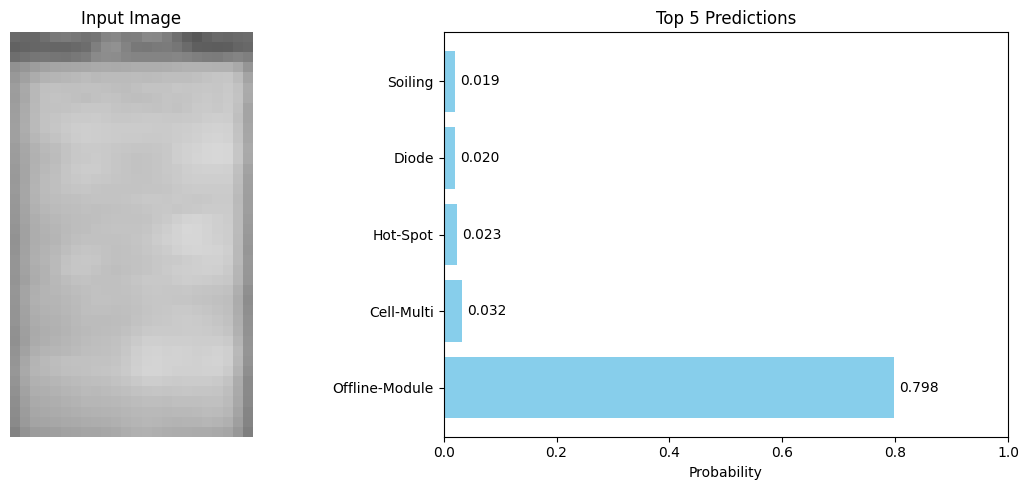

🎯 Prediction: Offline-Module (Confidence: 0.798)

📷 Stratified Sample 2: 16720.jpg
   📁 From class: images


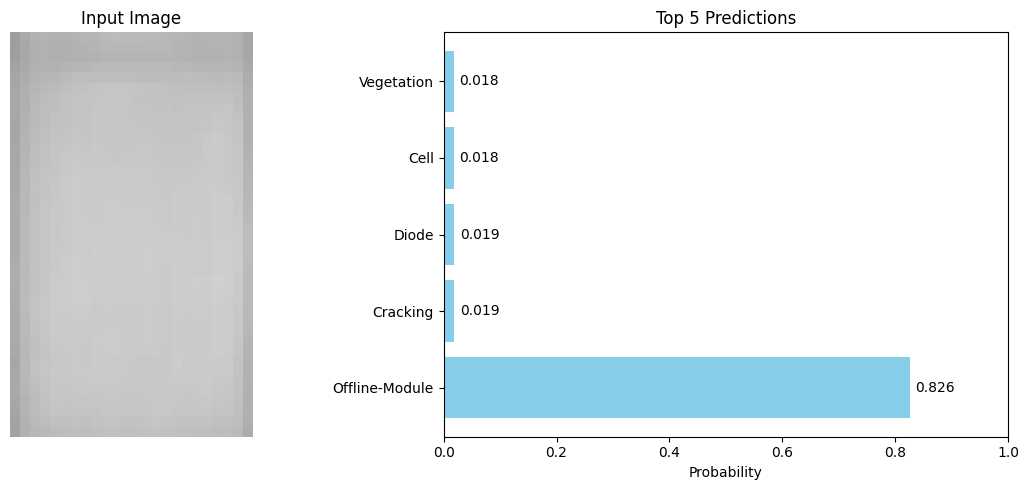

🎯 Prediction: Offline-Module (Confidence: 0.826)

📷 Stratified Sample 3: 7021.jpg
   📁 From class: images


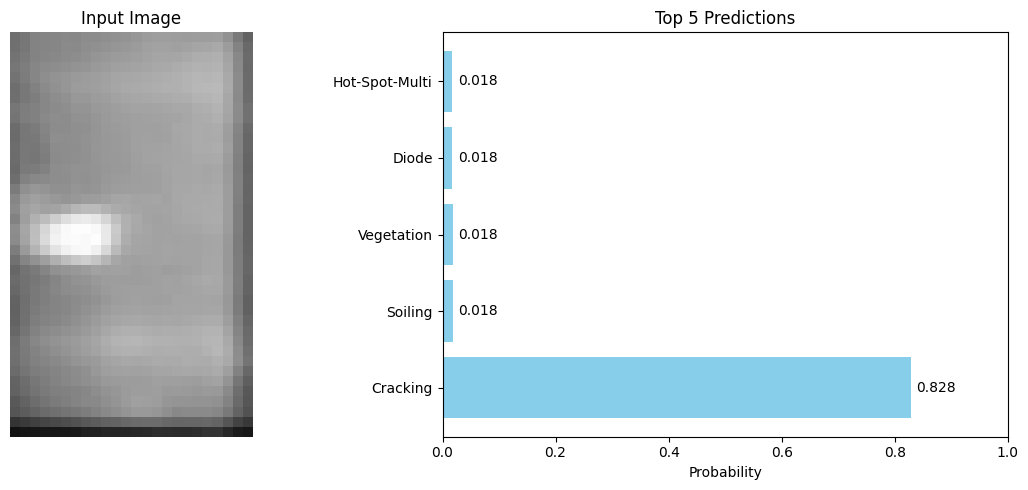

🎯 Prediction: Cracking (Confidence: 0.828)

📷 Stratified Sample 4: 16801.jpg
   📁 From class: images


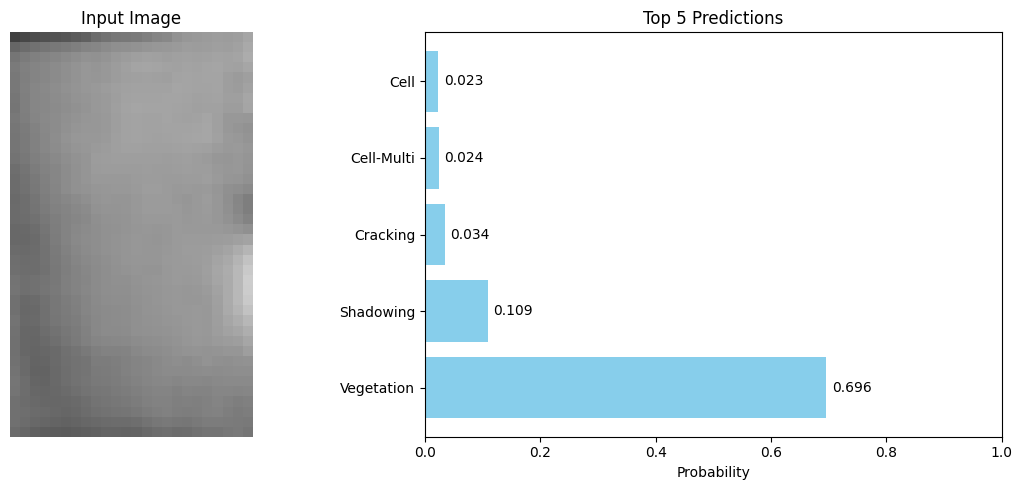

🎯 Prediction: Vegetation (Confidence: 0.696)

📷 Stratified Sample 5: 5842.jpg
   📁 From class: images


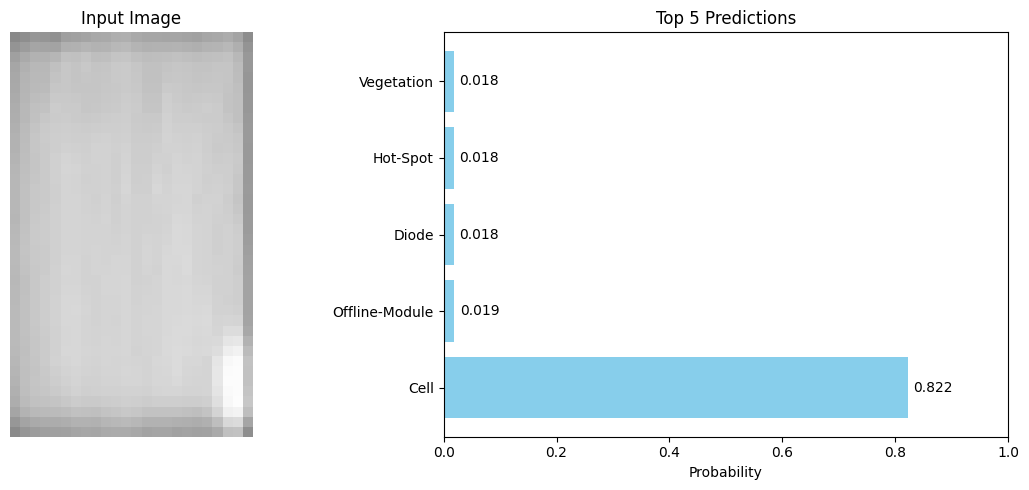

🎯 Prediction: Cell (Confidence: 0.822)

📷 Stratified Sample 6: 11786.jpg
   📁 From class: images


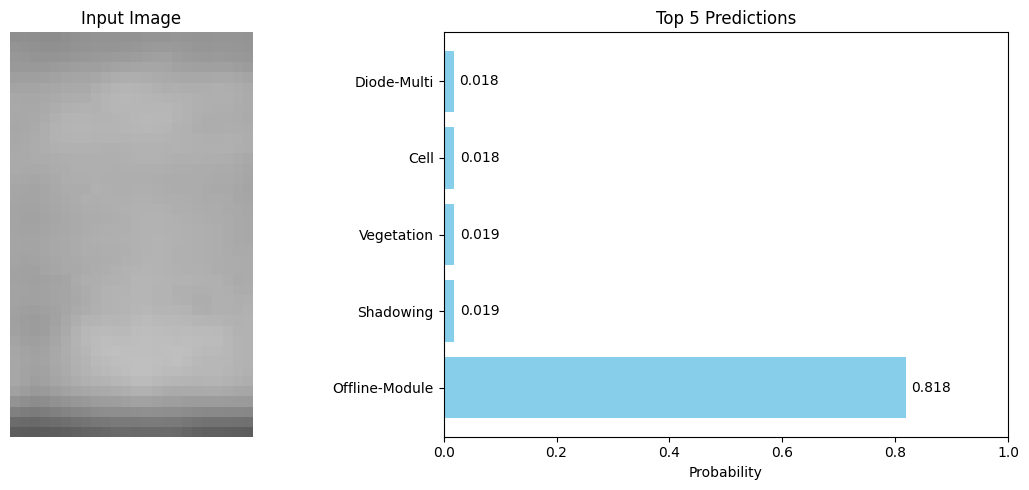

🎯 Prediction: Offline-Module (Confidence: 0.818)

📷 Stratified Sample 7: 5072.jpg
   📁 From class: images


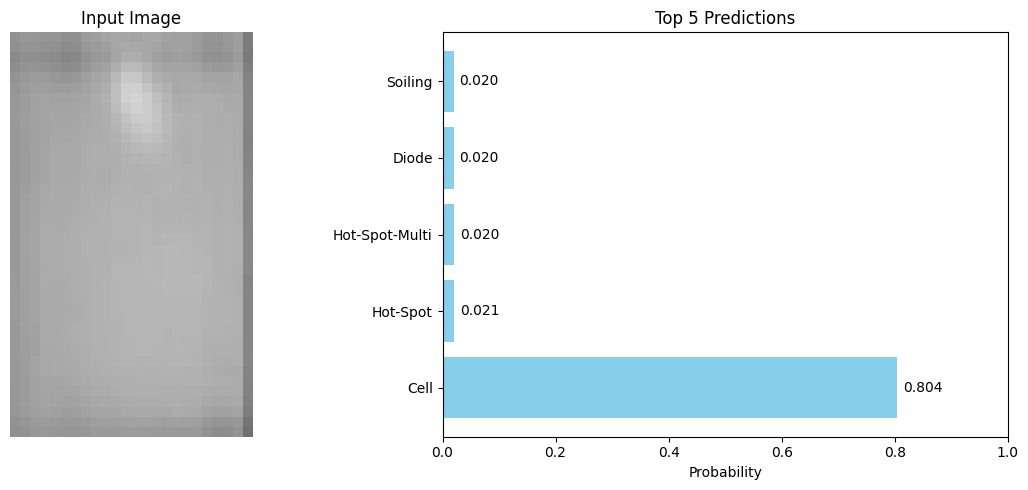

🎯 Prediction: Cell (Confidence: 0.804)

📷 Stratified Sample 8: 19041.jpg
   📁 From class: images


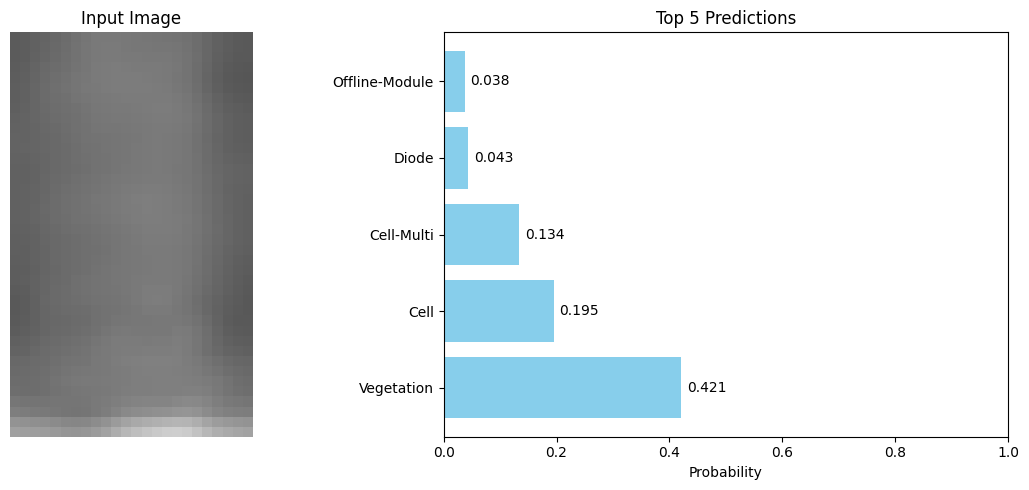

🎯 Prediction: Vegetation (Confidence: 0.421)

📷 Stratified Sample 9: 185.jpg
   📁 From class: images


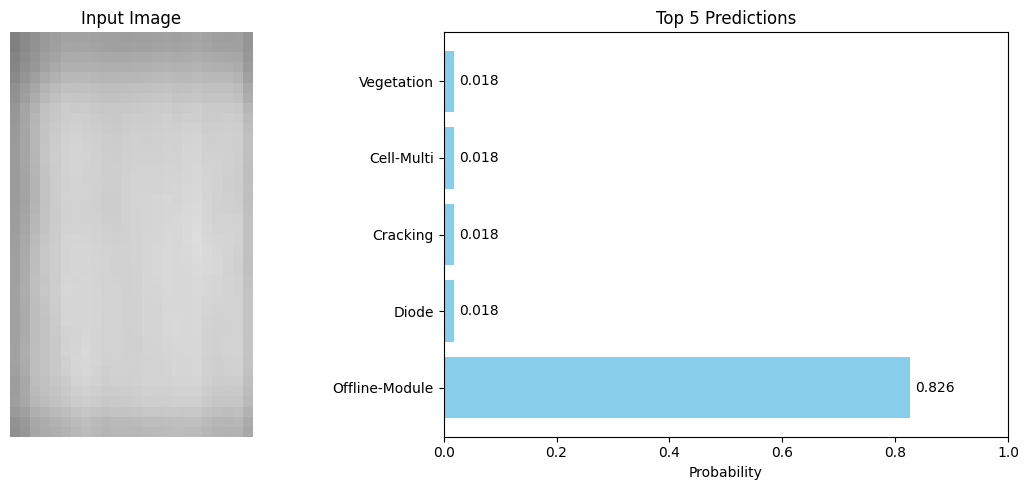

🎯 Prediction: Offline-Module (Confidence: 0.826)

📷 Stratified Sample 10: 6118.jpg
   📁 From class: images


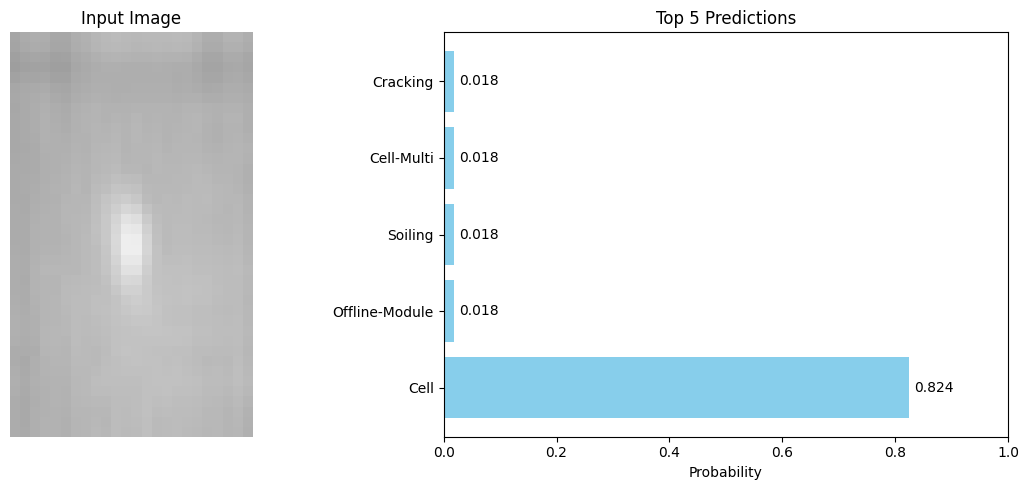

🎯 Prediction: Cell (Confidence: 0.824)

✅ Stratified sampling testing completed!

💡 To test a specific image, use:
visualize_prediction('full_path_to_your_image.jpg', model, transform, device, full_dataset.classes)

🚀 Use test_single_image('image_name.jpg') for quick testing of specific images
🎯 Use test_stratified_samples(num_samples=5) to test stratified samples across all classes


In [13]:
# Test the model with your own images
import os
import random
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit

# Define the transform for custom images (same as used during training)
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to your custom images
custom_images_path = r"C:\Users\Zeshan\Desktop\InfraredSolarModules"

# Check if the path exists
if os.path.exists(custom_images_path):
    print(f"✅ Found custom images directory: {custom_images_path}")
    
    # Get list of image files (common formats) - improved search
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    image_files = []
    image_labels = []  # Store labels for stratified sampling
    
    # Search in all subdirectories as well
    for root, dirs, files in os.walk(custom_images_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_path = Path(root) / file
                image_files.append(image_path)
                # Extract label from folder structure (parent folder name)
                label = Path(root).name
                image_labels.append(label)
    
    print(f"📸 Found {len(image_files)} images to test")
    
    if len(image_files) > 0:
        # Show class distribution
        from collections import Counter
        label_counts = Counter(image_labels)
        print(f"\n📊 Class distribution in custom dataset:")
        for label, count in label_counts.items():
            print(f"   {label}: {count} images")
        
        print("\n🔍 Testing stratified random samples from your custom images:")
        print("-" * 50)
        
        # Use StratifiedShuffleSplit for balanced sampling across classes
        num_samples = min(10, len(image_files))  # Take up to 10 stratified samples
        
        # Only proceed if we have at least 2 classes for stratification
        if len(label_counts) > 1:
            # Create stratified split
            sss = StratifiedShuffleSplit(n_splits=1, test_size=num_samples, random_state=42)
            
            try:
                # Get stratified sample indices
                _, sample_indices = next(sss.split(image_files, image_labels))
                stratified_sample = [image_files[i] for i in sample_indices]
                
                print(f"✅ Using StratifiedShuffleSplit for balanced sampling across {len(label_counts)} classes")
                
            except ValueError as e:
                # Fallback to random sampling if stratification fails
                print(f"⚠️ Stratification failed ({str(e)}), using random sampling instead")
                stratified_sample = random.sample(image_files, num_samples)
        else:
            # Single class - use random sampling
            print(f"ℹ️ Only one class found, using random sampling")
            stratified_sample = random.sample(image_files, num_samples)
        
        # Test each sample
        for i, img_path in enumerate(stratified_sample):
            print(f"\n📷 Stratified Sample {i+1}: {img_path.name}")
            print(f"   📁 From class: {Path(img_path).parent.name}")
            try:
                predicted_class, confidence = visualize_prediction(
                    str(img_path), 
                    model, 
                    transform, 
                    device, 
                    full_dataset.classes,
                    top_k=5
                )
                print(f"🎯 Prediction: {predicted_class} (Confidence: {confidence:.3f})")
                
            except Exception as e:
                print(f"❌ Error processing {img_path.name}: {str(e)}")
                continue
                
        print("\n" + "="*60)
        print("✅ Stratified sampling testing completed!")
        
        # Option to test a specific image
        print("\n💡 To test a specific image, use:")
        print("visualize_prediction('full_path_to_your_image.jpg', model, transform, device, full_dataset.classes)")
        
    else:
        print("❌ No image files found in the directory")
        print("   Supported formats: .jpg, .jpeg, .png, .bmp, .tiff, .tif")
        print("   Make sure images are directly in the folder or its subfolders")
        
        # List what's actually in the directory
        print(f"\n📁 Contents of {custom_images_path}:")
        try:
            items = list(os.listdir(custom_images_path))
            if items:
                for item in items[:10]:  # Show first 10 items
                    item_path = os.path.join(custom_images_path, item)
                    if os.path.isdir(item_path):
                        print(f"   📁 {item}/")
                    else:
                        print(f"   📄 {item}")
                if len(items) > 10:
                    print(f"   ... and {len(items) - 10} more items")
            else:
                print("   (Directory is empty)")
        except PermissionError:
            print("   (Permission denied to list directory contents)")
        
else:
    print(f"❌ Directory not found: {custom_images_path}")
    print("   Please check the path and try again")

# Function to test stratified random samples
def test_stratified_samples(num_samples=5):
    """
    Test stratified random samples from the custom directory using StratifiedShuffleSplit
    """
    if not os.path.exists(custom_images_path):
        print(f"❌ Directory not found: {custom_images_path}")
        return
    
    # Get all image files with labels
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    image_files = []
    image_labels = []
    
    for root, dirs, files in os.walk(custom_images_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_path = Path(root) / file
                image_files.append(image_path)
                # Extract label from folder structure
                label = Path(root).name
                image_labels.append(label)
    
    if len(image_files) == 0:
        print("❌ No images found in the directory")
        return
    
    # Show class distribution
    from collections import Counter
    label_counts = Counter(image_labels)
    print(f"📊 Found {len(label_counts)} classes with distribution:")
    for label, count in label_counts.items():
        print(f"   {label}: {count} images")
    
    # Use StratifiedShuffleSplit for balanced sampling
    num_samples = min(num_samples, len(image_files))
    
    if len(label_counts) > 1:
        try:
            sss = StratifiedShuffleSplit(n_splits=1, test_size=num_samples, random_state=42)
            _, sample_indices = next(sss.split(image_files, image_labels))
            stratified_sample = [image_files[i] for i in sample_indices]
            print(f"\n🎯 Using StratifiedShuffleSplit for {num_samples} balanced samples:")
        except ValueError as e:
            print(f"⚠️ Stratification failed ({str(e)}), using random sampling")
            stratified_sample = random.sample(image_files, num_samples)
    else:
        print(f"\nℹ️ Single class detected, using random sampling for {num_samples} samples:")
        stratified_sample = random.sample(image_files, num_samples)
    
    print("-" * 40)
    
    for i, img_path in enumerate(stratified_sample):
        print(f"\n📷 Sample {i+1}: {img_path.name}")
        print(f"   📁 Class: {Path(img_path).parent.name}")
        try:
            predicted_class, confidence = visualize_prediction(
                str(img_path), 
                model, 
                transform, 
                device, 
                full_dataset.classes,
                top_k=3
            )
            print(f"🎯 Prediction: {predicted_class} (Confidence: {confidence:.3f})")
        except Exception as e:
            print(f"❌ Error processing {img_path.name}: {str(e)}")

# Quick test function for individual images
def test_single_image(image_name):
    """
    Quick function to test a single image by name from your custom directory
    """
    # Search for the image in the directory and subdirectories
    for root, dirs, files in os.walk(custom_images_path):
        if image_name in files:
            image_path = os.path.join(root, image_name)
            return visualize_prediction(image_path, model, transform, device, full_dataset.classes)
    
    print(f"❌ Image not found: {image_name}")
    print("   Available images:")
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    found_images = []
    for root, dirs, files in os.walk(custom_images_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                found_images.append(file)
    
    if found_images:
        # Show random sample of available images
        sample_size = min(5, len(found_images))
        random_sample = random.sample(found_images, sample_size)
        for img in random_sample:
            print(f"   📷 {img}")
        if len(found_images) > 5:
            print(f"   ... and {len(found_images) - 5} more images")
    else:
        print("   (No images found)")
    
    return None, None

print("\n🚀 Use test_single_image('image_name.jpg') for quick testing of specific images")
print("🎯 Use test_stratified_samples(num_samples=5) to test stratified samples across all classes")


🔄 Computing predictions with probabilities for ROC analysis...


Computing ROC predictions: 100%|██████████| 145/145 [00:21<00:00,  6.73it/s]


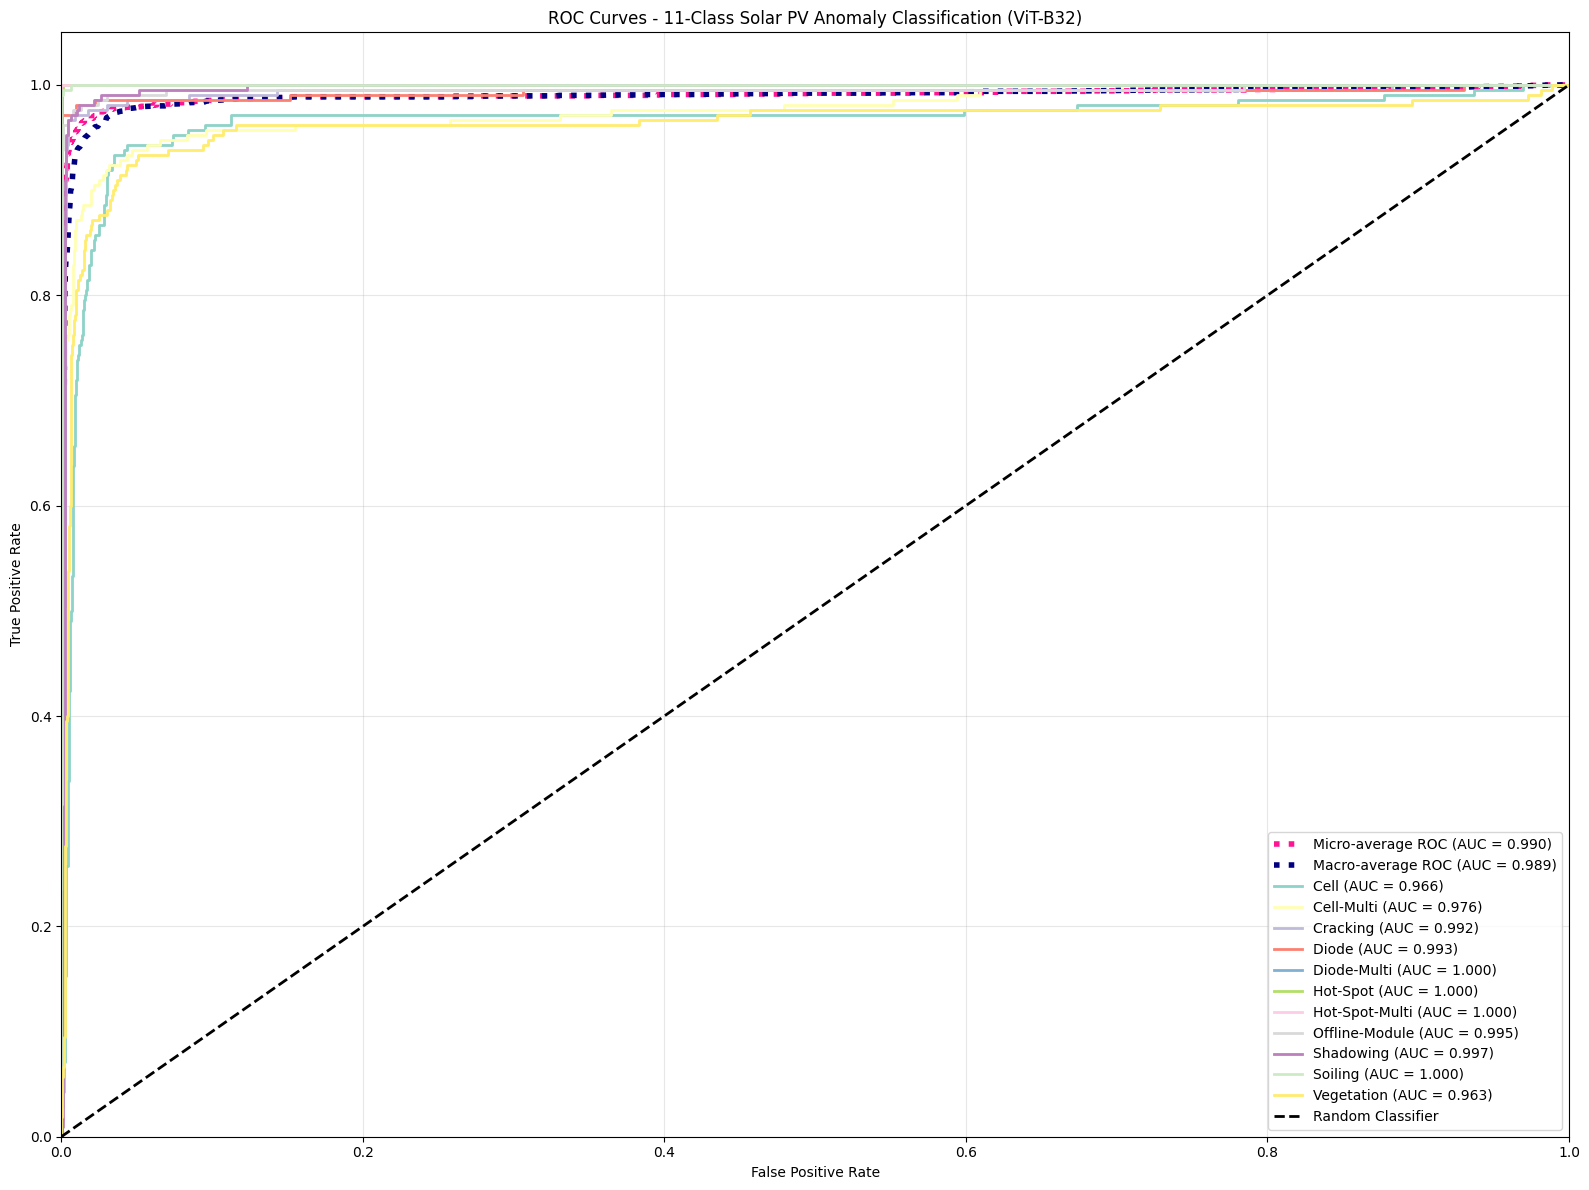


📊 ROC AUC Scores:
Class           AUC Score 
-------------------------
Cell            0.966     
Cell-Multi      0.976     
Cracking        0.992     
Diode           0.993     
Diode-Multi     1.000     
Hot-Spot        1.000     
Hot-Spot-Multi  1.000     
Offline-Module  0.995     
Shadowing       0.997     
Soiling         1.000     
Vegetation      0.963     
-------------------------
Micro-average   0.990     
Macro-average   0.989     

💾 ROC AUC results saved to results\11_class_pytorch/roc_auc_scores_vitb32_11class.json
📊 ROC curves plot saved to results\11_class_pytorch/roc_curves_vitb32_11class.png


In [14]:
# ROC AUC Analysis for Multi-class Classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc_auc(y_true, y_pred_proba, class_names, save_path):
    """
    Plot ROC curves and calculate AUC for multi-class classification
    """
    n_classes = len(class_names)
    
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(16, 12))
    
    # Plot micro and macro averages
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
             color='navy', linestyle=':', linewidth=4)
    
    # Plot ROC curve for each class
    colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - 11-Class Solar PV Anomaly Classification (ViT-B32)')
    # LEGEND LOCATION DEFINITION - Changed to bottom right inside the plot:
    # Original: plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') - outside plot, top right
    # New: loc='lower right' - inside plot, bottom right corner
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path / 'roc_curves_vitb32_11class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print AUC scores
    print("\n📊 ROC AUC Scores:")
    print(f"{'Class':<15} {'AUC Score':<10}")
    print("-" * 25)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} {roc_auc[i]:<10.3f}")
    print("-" * 25)
    print(f"{'Micro-average':<15} {roc_auc['micro']:<10.3f}")
    print(f"{'Macro-average':<15} {roc_auc['macro']:<10.3f}")
    
    return roc_auc

# Get predictions with probabilities for ROC analysis
print("🔄 Computing predictions with probabilities for ROC analysis...")
model.eval()
all_predictions = []
all_probabilities = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Computing ROC predictions"):
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        
        all_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
y_true_roc = np.array(all_labels)
y_pred_proba_roc = np.array(all_probabilities)

# Plot ROC curves and calculate AUC scores
roc_auc_scores = plot_multiclass_roc_auc(
    y_true_roc, 
    y_pred_proba_roc, 
    full_dataset.classes, 
    RESULTS_PATH
)

# Save ROC AUC results
roc_results = {
    'per_class_auc': {class_name: float(roc_auc_scores[i]) 
                      for i, class_name in enumerate(full_dataset.classes)},
    'micro_average_auc': float(roc_auc_scores['micro']),
    'macro_average_auc': float(roc_auc_scores['macro'])
}

with open(RESULTS_PATH / 'roc_auc_scores_vitb32_11class.json', 'w') as f:
    json.dump(roc_results, f, indent=4)

print(f"\n💾 ROC AUC results saved to {RESULTS_PATH}/roc_auc_scores_vitb32_11class.json")
print(f"📊 ROC curves plot saved to {RESULTS_PATH}/roc_curves_vitb32_11class.png")


🔄 Generating t-SNE visualization for ViT-B32 model...
📊 Extracting features from test set...


Extracting features for t-SNE:  86%|████████▌ | 125/145 [00:21<00:03,  5.87it/s]


✅ Extracted 2000 samples with 768 features each
🔄 Running t-SNE with perplexity=30, max_iter=1000...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 1.852s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.189311
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.296909
[t-SNE] KL divergence after 1000 iterations: 0.601176


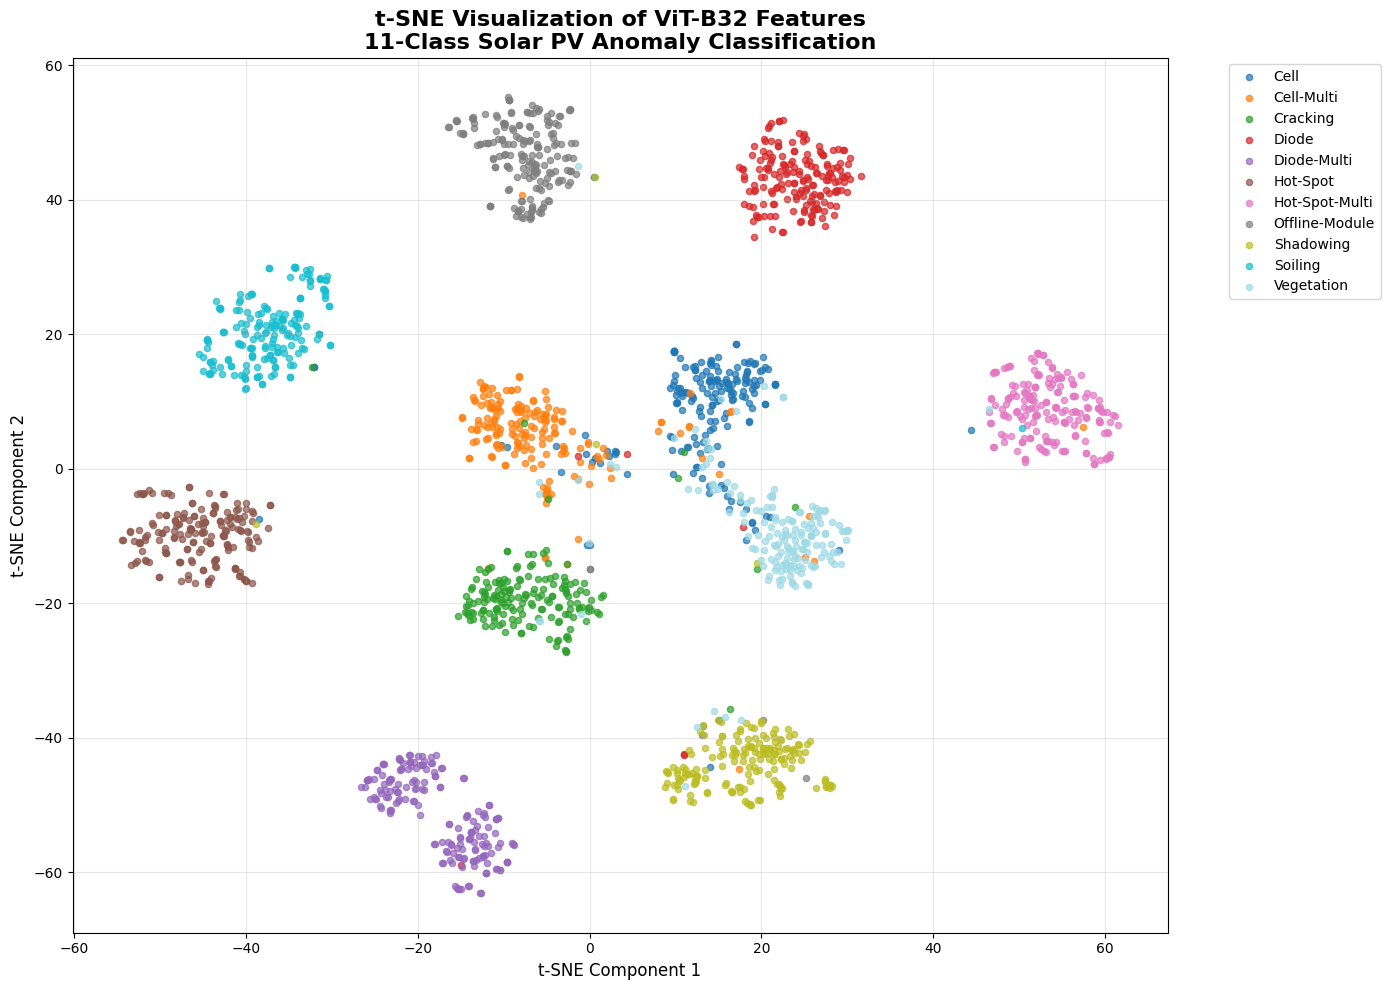


💾 t-SNE results saved to results\11_class_pytorch/tsne_results_vitb32_11class.json
📊 t-SNE visualization saved to results\11_class_pytorch/tsne_visualization_vitb32_11class.png

📊 Cluster Separation Analysis:
--------------------------------------------------
Average intra-class distance: 10.064
Average inter-class distance: 56.622
Separation ratio (inter/intra): 5.626
✅ Good cluster separation (ratio > 2.0)

💾 Cluster metrics saved to results\11_class_pytorch/tsne_cluster_metrics_vitb32_11class.json

🎯 t-SNE analysis completed!


In [15]:
# t-SNE Visualization for ViT-B32 11-Class Model
print("🔄 Generating t-SNE visualization for ViT-B32 model...")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

def extract_features_for_tsne(model, data_loader, device, max_samples=2000):
    """
    Extract features from the model's backbone for t-SNE visualization
    """
    model.eval()
    features = []
    labels = []
    sample_count = 0
    
    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting features for t-SNE"):
            if sample_count >= max_samples:
                break
                
            images = images.to(device)
            
            # Extract features from backbone (before classification head)
            backbone_features = model.backbone(images)
            
            # Flatten features if needed
            if len(backbone_features.shape) > 2:
                backbone_features = backbone_features.view(backbone_features.size(0), -1)
            
            features.extend(backbone_features.cpu().numpy())
            labels.extend(batch_labels.numpy())
            
            sample_count += len(batch_labels)
    
    return np.array(features), np.array(labels)

def plot_tsne_visualization(features, labels, class_names, save_path, perplexity=30, max_iter=1000):
    """
    Create and plot t-SNE visualization
    """
    print(f"🔄 Running t-SNE with perplexity={perplexity}, max_iter={max_iter}...")
    
    # Apply t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=max_iter,
        random_state=42,
        verbose=1
    )
    
    tsne_results = tsne.fit_transform(features)
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    
    # Define colors for each class
    colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))
    
    # Plot each class
    for i, class_name in enumerate(class_names):
        mask = labels == i
        plt.scatter(
            tsne_results[mask, 0], 
            tsne_results[mask, 1],
            c=[colors[i]], 
            label=class_name,
            alpha=0.7,
            s=20
        )
    
    plt.title('t-SNE Visualization of ViT-B32 Features\n11-Class Solar PV Anomaly Classification', 
              fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    # Adjust legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    tsne_filename = 'tsne_visualization_vitb32_11class.png'
    plt.savefig(save_path / tsne_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return tsne_results

# Extract features from test set for t-SNE
print("📊 Extracting features from test set...")
test_features, test_labels = extract_features_for_tsne(
    model, 
    test_loader, 
    device, 
    max_samples=2000  # Limit samples for faster computation
)

print(f"✅ Extracted {len(test_features)} samples with {test_features.shape[1]} features each")

# Generate t-SNE visualization
tsne_results = plot_tsne_visualization(
    test_features,
    test_labels,
    full_dataset.classes,
    RESULTS_PATH,
    perplexity=30,
    max_iter=1000
)

# Save t-SNE results
tsne_data = {
    'tsne_coordinates': tsne_results.tolist(),
    'labels': test_labels.tolist(),
    'class_names': full_dataset.classes,
    'parameters': {
        'perplexity': 30,
        'max_iter': 1000,
        'n_samples': len(test_features)
    }
}

with open(RESULTS_PATH / 'tsne_results_vitb32_11class.json', 'w') as f:
    json.dump(tsne_data, f, indent=4)

print(f"\n💾 t-SNE results saved to {RESULTS_PATH}/tsne_results_vitb32_11class.json")
print(f"📊 t-SNE visualization saved to {RESULTS_PATH}/tsne_visualization_vitb32_11class.png")

# Additional analysis: Calculate cluster separation metrics
def calculate_cluster_metrics(tsne_results, labels, class_names):
    """
    Calculate basic cluster separation metrics
    """
    from scipy.spatial.distance import pdist, squareform
    
    print("\n📊 Cluster Separation Analysis:")
    print("-" * 50)
    
    # Calculate intra-class and inter-class distances
    intra_class_distances = []
    inter_class_distances = []
    
    for i, class_name in enumerate(class_names):
        class_mask = labels == i
        class_points = tsne_results[class_mask]
        
        if len(class_points) > 1:
            # Intra-class distances (within class)
            intra_distances = pdist(class_points)
            intra_class_distances.extend(intra_distances)
            
            # Inter-class distances (between this class and others)
            other_points = tsne_results[~class_mask]
            if len(other_points) > 0:
                for point in class_points:
                    distances_to_others = np.sqrt(np.sum((other_points - point)**2, axis=1))
                    inter_class_distances.extend(distances_to_others)
    
    avg_intra_distance = np.mean(intra_class_distances) if intra_class_distances else 0
    avg_inter_distance = np.mean(inter_class_distances) if inter_class_distances else 0
    
    separation_ratio = avg_inter_distance / avg_intra_distance if avg_intra_distance > 0 else float('inf')
    
    print(f"Average intra-class distance: {avg_intra_distance:.3f}")
    print(f"Average inter-class distance: {avg_inter_distance:.3f}")
    print(f"Separation ratio (inter/intra): {separation_ratio:.3f}")
    
    if separation_ratio > 2.0:
        print("✅ Good cluster separation (ratio > 2.0)")
    elif separation_ratio > 1.5:
        print("⚠️  Moderate cluster separation (1.5 < ratio < 2.0)")
    else:
        print("❌ Poor cluster separation (ratio < 1.5)")
    
    return {
        'avg_intra_distance': float(avg_intra_distance),
        'avg_inter_distance': float(avg_inter_distance),
        'separation_ratio': float(separation_ratio)
    }

# Calculate and display cluster metrics
cluster_metrics = calculate_cluster_metrics(tsne_results, test_labels, full_dataset.classes)

# Save cluster metrics
with open(RESULTS_PATH / 'tsne_cluster_metrics_vitb32_11class.json', 'w') as f:
    json.dump(cluster_metrics, f, indent=4)

print(f"\n💾 Cluster metrics saved to {RESULTS_PATH}/tsne_cluster_metrics_vitb32_11class.json")
print("\n🎯 t-SNE analysis completed!")
